In [1]:
#CONVOLUTIONAL NEURAL NETWORK

#https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
#https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
import torch
from torch import nn
import torch.nn.functional as F
from IPython.display import Image

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

"""
Grouping unlabeled examples is called clustering.
"""

#Razlika izmedju klasterizacije i klasifikacije
"""
Classification sorts data into specific categories using a labeled dataset.
Clustering is partitioning an unlabeled dataset into groups of similar objects.
------------
Klasifikacija sortira podatke u određene kategorije koristeći označeni skup podataka.
Klasterizacija je particionisanje neoznačenog skupa podataka u grupe sličnih objekata.
"""

'\nClassification sorts data into specific categories using a labeled dataset.\nClustering is partitioning an unlabeled dataset into groups of similar objects.\n------------\nKlasifikacija sortira podatke u određene kategorije koristeći označeni skup podataka.\nKlasterizacija je particionisanje neoznačenog skupa podataka u grupe sličnih objekata.\n'

In [2]:
from struct import *
import numpy as np

def ucitaj_minst(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        #print(magic_number)
        broj_slika = unpack(">I", fp.read(4))[0]
        broj_redova = unpack(">I", fp.read(4))[0]
        broj_kolona = unpack(">I", fp.read(4))[0]
        
        slike = np.frombuffer(fp.read(broj_slika*broj_redova*broj_kolona), dtype=np.uint8).reshape((broj_slika, broj_redova, broj_kolona))
        slike = slike.astype(np.float32)/255 #moramo konverovati u float32 da bi se uskladio sa neuronskom mrezom
        return slike                    #podelili samo sa 255 ocekujuci da dobijemo vrednosti u rasponu 0-1
        
def ucitaj_minst_labele(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_labela = unpack(">I", fp.read(4))[0]
        
        labele = np.frombuffer(fp.read(broj_labela), dtype=np.uint8)
        return labele

In [3]:
#prepravljamo
class MinstDataset(Dataset):   
    def __init__(self, putanja_podaci, putanja_labele):    
        super().__init__()
        
        slike = ucitaj_minst(putanja_podaci)
        labele = ucitaj_minst_labele(putanja_labele)
        
        #print(np.random.random((1000, 28, 28))
        
        #prazne_slike = np.random.random((1000, 28,28)).astype(np.float32) #pravimo 1000 praznih slika
        prazne_slike = np.zeros((1000, 28,28)).astype(np.float32) #pravimo 1000 praznih slika
        labele_prazne = np.ones(1000, dtype=np.uint8)*10
        labele = np.concatenate((labele, labele_prazne))
        slike = np.concatenate((slike, prazne_slike))     #ubacili smo u slike
        
        self.podaci = list(zip(slike.reshape(len(slike), 1, slike[0].shape[0], slike[0].shape[1]), labele))
                                                    #svaka slika je niz koji u sebi sadrzi niz nizova koji u sebi sadrzi matricu
    def __len__(self):    
        return len(self.podaci)

    def __getitem__(self, indeks):    
        return self.podaci[indeks]
    
minst_podaci = MinstDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
minst_podaci2 = MinstDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")
minst_trening_podaci = DataLoader(minst_podaci, batch_size=4, shuffle=True)
minst_test_podaci = DataLoader(minst_podaci2, batch_size=4, shuffle=True)

In [4]:
#https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d
class CnnMreza(nn.Module):
    def __init__(self):
        super(CnnMreza, self).__init__()
        self.prvi_sloj = nn.Conv2d(1, 5, 3, padding=1)  #u prvom sloju radimo sa 2 dimenzionim slikama
        self.drugi_sloj = nn.Conv2d(5, 10, 3, padding=1)
        
        self.prvi_linearni_sloj = nn.Linear(10*28*28, 500)#linearni sloj moze primiti samo vektor, ne moze matricu
                                            #10 izlaza, dimenzija 28x28
        self.drugi_linearni_sloj = nn.Linear(500, 200)
        # self.treci_sloj = nn.Linear(200, 100)
        # self.cetvrti_sloj = nn.Linear(100, 10) 
                    
    def forward(self, x):
        prvi_sloj_izlaz = F.tanh(self.prvi_sloj(x)) #tanh - aktivaciona funkcija
        drugi_sloj_izlaz = F.tanh(self.drugi_sloj(prvi_sloj_izlaz))
        
        treci_sloj_izlaz = F.tanh(self.prvi_linearni_sloj(drugi_sloj_izlaz.view(-1, 10*28*28)))
                                                                      #prepravimo matricu da bude obican niz,
                                                                      #raspakujemo jednu dimenziju, ostalo prekujemo da bude dimenziija 10*28*28
                                                                      #mozemo i sa flatten uraditi, https://pytorch.org/docs/stable/generated/torch.flatten.html#torch-flatten
                                                                      #vraca original objekat
        return F.tanh(self.drugi_linearni_sloj(treci_sloj_izlaz))
    
#posto su slike monohromatske u ovom slucaju, bice 1 ulazni kanal
#hocemo da dobijemo izlaz gde kaze kojoj klasi pripada
#napravimo smo konvolutivnu neuronsku mrezu koja ima namenu klasifikacije

In [6]:
#obucavanje
mreza = CnnMreza()
"""
Cross entropy loss is a metric used to measure how well a classification model in machine learning performs. 
The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model. 
The goal is generally to get your model as close to 0 as possible
"""
funkcija_greske = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mreza.parameters(), lr=0.001, momentum=0.9)   #sigmoid funkcija
                                                 #menjali smo learing rate da vidimo koliko ce pomoci u obucavanju
#nasa implementaicija, link dole do doc ↓
#https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation
for epoha in range(1):
    for (x, y) in minst_trening_podaci:
        #print(x, y)
        predikcija = mreza(x)
        
        optimizer.zero_grad()    #resetujemo da se ne pamte izracunavanja od ranije
        greska = funkcija_greske(predikcija, y) #prosledjivanje funkciji greske da izmerimo distorziju
        greska.backward()
        optimizer.step()

In [7]:
tacnih = 0

for el in minst_test_podaci:
    rezulat = mreza(el[0])
    predikcija = torch.argmax(rezulat, 1)
    tacnih += (predikcija == el[1].sum())

print(tacnih/len(minst_podaci2))

tensor([0.0008, 0.0007, 0.0011, 0.0005])


In [ ]:
#za nekih 2-3% je ova arhitektura bolje od prethodne gde smo imali samo potpuno povezanu mrezu
#prva dva konvolutivna sloja izvlace bitne osobine sa slike, a onda ovi na osnovu tih potpuno bitnih osobine dalje rasudjuju
#linearni slojevi ne rade sa celom slikom, dobijaju pripremljen input gde mogu nesto sa njih da izvuku


#https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d

#sl put - napravicemo neuronsku mrezu koju cemo koristi da sa velike slike izdvojimo pojave cifara
#dobijemo sliku 1024x1024, nas interesuje gde se nalaze brojevi 10 na slici

#zadatak za kol moze biti npr. da sumiramo sve brojeve sa slike i sacuvamo rezultat

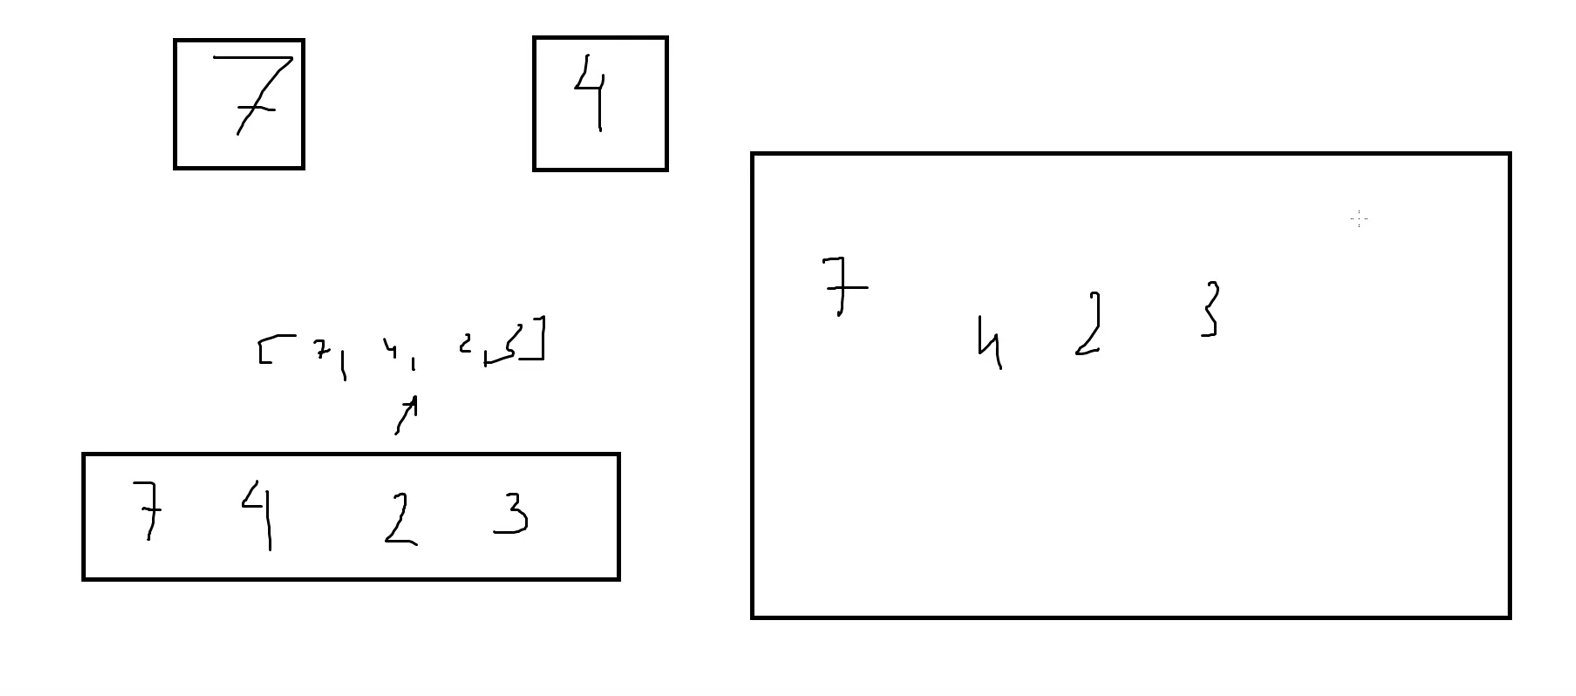

In [8]:
#nastavak(01-12-2022)-izvuci brojeve sa tablice i smestiti u niz

t = Image(filename='tablica.png')
t

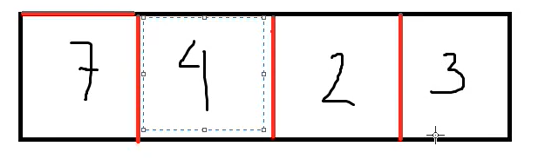

In [8]:
#1.Podelimo sliku na pojedinacke slike
#2.Izdvojimo svaku pojedinacku slicicu i nju propustamo kroz neuronsku mrezu. Isekcemo pod slike ove slike, slicice su 28x28
#jednu po jednu izdvajamo

n = Image(filename='izdvojeno.png')
n

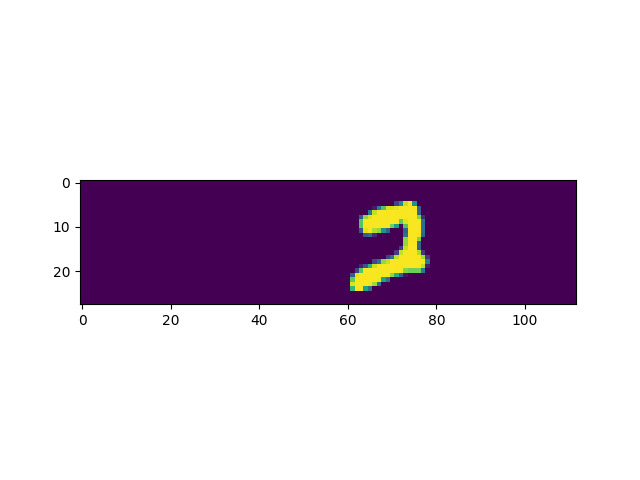

In [95]:
tablica = np.zeros((28, 28*4))   #na ovo stavljamo slike, petu cifru nemamo jer nam je batch size 4, stavicemo 4 za sada ovde

cifre = next(iter(minst_trening_podaci))

#print(cifre)

for i, c in enumerate(cifre[0]):
    if i%2 == 0:
        tablica[0:28, i*28:(i+1)*28] = c.numpy()  #pomeramo se za jednu, ovaj ceo skup predstavlja feature vektore
# tablice[0:28*2, 0:28] = cifre[1]
# tablice[28*2:28*3, 0:28] = cifre[2]

plt.figure()
plt.imshow(tablica)
plt.show()

In [96]:
#sada hocemo da dobijemo ove brojeve zapisane u niz [8, 4, 4, 0]

rezultat = []

for i in range(4):
    rezultat.append(mreza(torch.from_numpy(tablica[0:28, i*28:(i+1)*28].reshape(1, 28, 28).astype(np.float32))))    #ocekuje torch tensor, prebacili smo u float 32 i reshape zbog 3D
print(list(map(lambda x: torch.argmax(x).item(), rezultat)))

#sa item vadimo vrednosti
#rezultat je npr predikcija za prvu cifru, govori nam da li pripada nekoj klasi, ako je -1 onda ne pripada ako je +1 pripada

[7, 7, 1, 7]


C:\Python310\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


C:\Users\Anja\AppData\Local\Temp\ipykernel_15328\3555512319.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


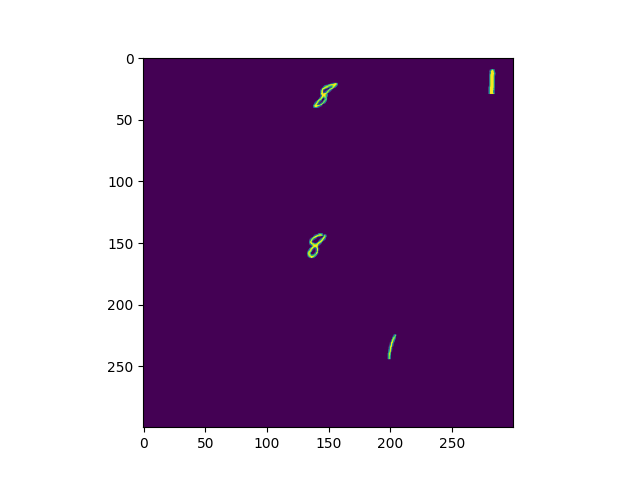

In [91]:
#Velika slika sa nasumice odabanim ciframa
#generisemo heatmap-ere

veika_slika = np.zeros((300, 300))  #dimenizije praznih


cifre = next(iter(minst_trening_podaci))

koordinate = np.random.randint(0, 300-28, size=(4, 2)) #maksimalno idemo nadesno do 300-28

for i, c in enumerate(cifre[0]):
        veika_slika[koordinate[i][0]:koordinate[i][0]+28, koordinate[i][1]:koordinate[i][1]+28] = c.numpy()

plt.figure()
plt.imshow(veika_slika)
plt.show()

In [103]:
heatmapa = np.zeros((11, 300, 300))  #bice sacinjena od 0 inijalno, dimenzija kao velika slika
#svaki sloj heatmape zaduzen je za jednu klasu

for i in range(0, 300-28):   #-28 da ne probijemo desnu ivicu
    for j in range(0, 300-28):
        mala_slika = torch.from_numpy(veika_slika[i:i+28, j:j+28].reshape(1, 28, 28).astype(np.float32))    #izdvajamo malu sliku sa velike slike
        #moramo je transformisati u oblik da bi je neurosnka mreza mogla koristiti
        rezultat_za_heat_mapu = mreza(mala_slika)
        
        max_vrednost = rezultat_za_heat_mapu.max().item()
        indeks = torch.argmax(rezultat_za_heat_mapu).item() #index maksimalne pobude
        if max_vrednost > 0.9:
            heatmapa[indeks][i:i+28, j:j+28] += 1 #zapisujemo u odgovarajuci sloj i tamo gde smo detektovali sum hocemo da se obelezi cisto da vidimo rezultat
        #print(rezultat_za_heat_mapu)

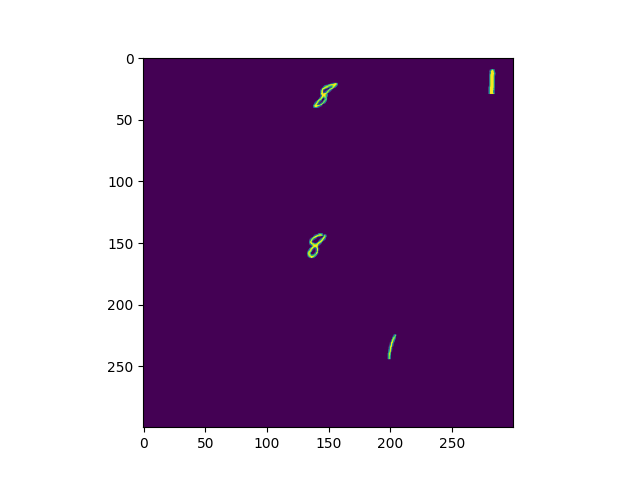

-----------------------------------------------------------------------------------------


TypeError: Invalid shape (11, 300, 300) for image data

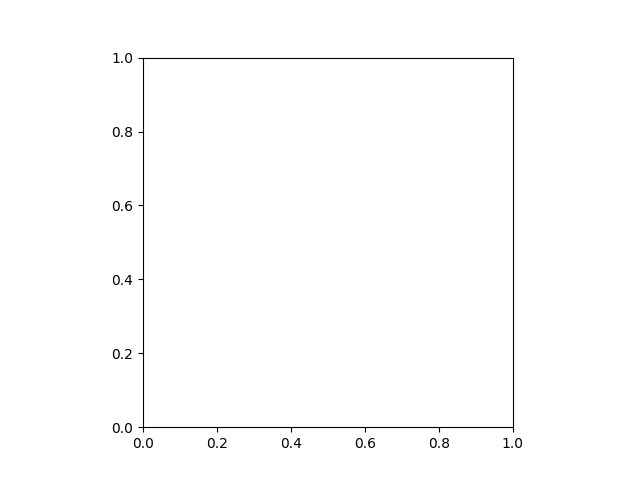

In [115]:
plt.figure()
plt.imshow(veika_slika)
plt.show()

print("-----------------------------------------------------------------------------------------")

plt.figure()
plt.imshow(heatmapa[3])  #za trojku, oznacava da je tu najverovatnije 3
plt.show()

#primenom sliding window - pomeramo ga i vrsimo klasifikaciju, to je prozor koji se pomera za po jedan piksel pa kad dodje do krajnje
#dense ivice spusti se ka dole za jedan piksel i vrati se na pocetak i ponavlja to sve
#svaki put kad se prozor pomeri mi izvadimo sliku koja se nalazila prethodno u njemu i vrsimo klasifikaciju te jedne male slike
#kada dobijemo rezultat upisujemo ga u neku izlaznu veliku sliku, i na taj nacin dobijamo detekciju cifara.

#svaki sloj sadrzi informacije o tome gde se koja cifra nalazi
#sledeci put cemo prosiriti ovo tako da radi brze i dosta bolje
#na ulaz cemo dostavljati velike slike a kao labelu koristimo heatmapu i moracemo funk greske promeniti,
#necemo vise raditi klasifikaciju vec regresiju

In [ ]:
#napravicemo endtoend obucavanje